In [42]:
import folium
from rasterio import mask
import rasterio
import laspy
import numpy as np
import mapclassify as mc
import pathlib
import pandas as pd
import imageio
import warnings
from rasterio.plot import plotting_extent
from glob import glob
import matplotlib.pyplot as plt
import earthpy.spatial as es
import earthpy.plot as ep
import geopandas as gpd
import rasterio as rio
import earthpy as et
import pickle
import os
import matplotlib.colors as colors



warnings.filterwarnings('ignore')

In [43]:
from pysheds.grid import Grid

In [44]:
grid = Grid.from_raster('../data/tif/dem.tif', data_name='dem')
print(grid.shape)
grid.view('dem')

(359, 367)


Raster([[214, 212, 210, ..., 177, 177, 175],
        [214, 210, 207, ..., 176, 176, 174],
        [211, 209, 204, ..., 174, 174, 174],
        ...,
        [263, 262, 263, ..., 217, 217, 216],
        [266, 265, 265, ..., 217, 217, 217],
        [268, 267, 266, ..., 216, 217, 216]], dtype=int16)

In [45]:
# Determine D8 flow directions from DEM
# ----------------------
# Resolve flats in DEM
grid.resolve_flats('dem', out_name='inflated_dem')

# Specify directional mapping
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

# Compute flow directions
# -------------------------------------
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
grid.view('dir')

Raster([[  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   2.,   2., ...,   4.,   1.,   0.],
        [  0.,   1.,   2., ...,   4.,   2.,   0.],
        ...,
        [  0.,  64.,  32., ...,   8.,   1.,   0.],
        [  0.,  64.,  32., ...,  16., 128.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]], dtype=float32)

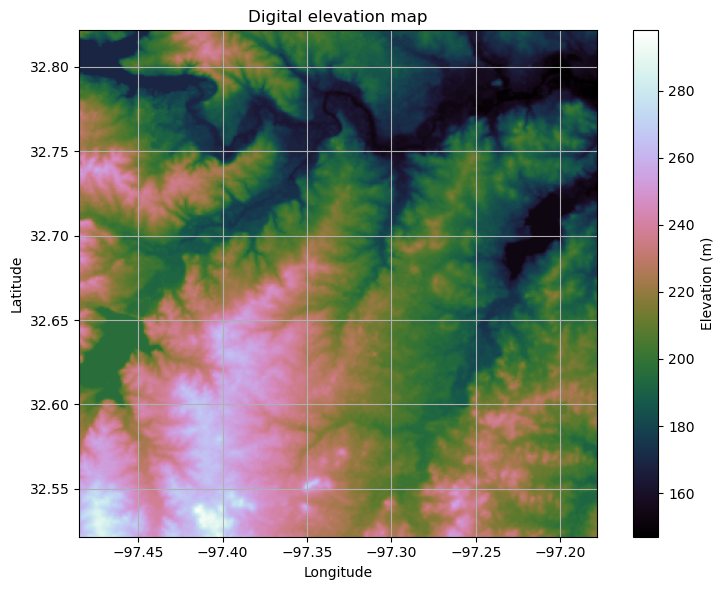

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='cubehelix', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.grid(zorder=0)
plt.title('Digital elevation map')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

In [47]:
# Delineate a catchment
# ---------------------
# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Crop and plot the catchment
# ---------------------------
# Clip the bounding box to the catchment
grid.clip_to('catch')
grid.view('catch')


Raster([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [48]:
grid.clip_to('catch')

In [49]:
# Get a view of the catchment
catch = grid.view('catch', nodata=np.nan)

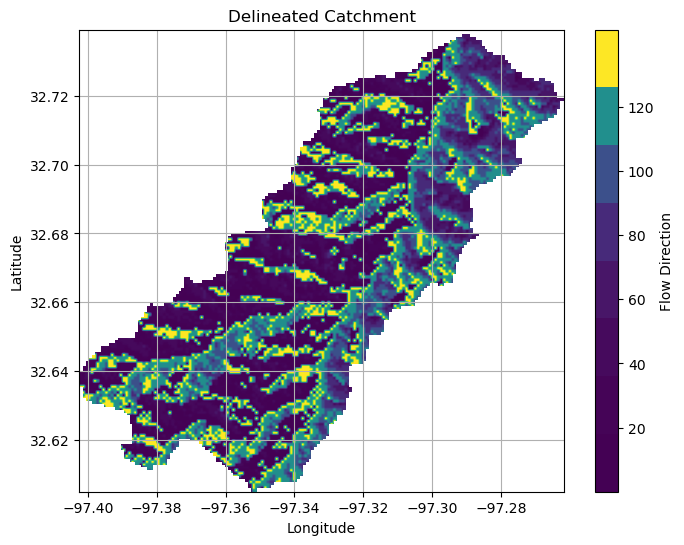

In [50]:
# Plot the catchment
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)

plt.grid('on', zorder=0)
im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
plt.colorbar(im, ax=ax, values=sorted(dirmap), label='Flow Direction')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Delineated Catchment')
plt.show()


In [51]:
grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

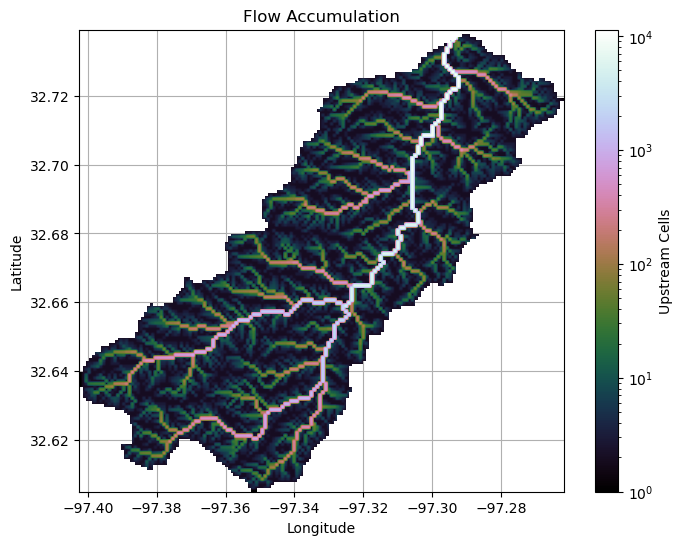

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
acc_img = np.where(grid.mask, grid.acc + 1, np.nan)
im = ax.imshow(acc_img, extent=grid.extent, zorder=2,
               cmap='cubehelix',
               norm=colors.LogNorm(1, grid.acc.max()))
plt.colorbar(im, ax=ax, label='Upstream Cells')
plt.title('Flow Accumulation')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Calculating slope


In [3]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import richdem as rd

In [56]:
matplotlib.rcParams['figure.figsize'] = (8, 5.5)

In [1]:
dem_path = os.path.join(os.getcwd(), '../data/tif/dem.tif')

In [4]:
shasta_dem = rd.LoadGDAL(dem_path)

In [6]:
shasta_dem.shape

(359, 367)

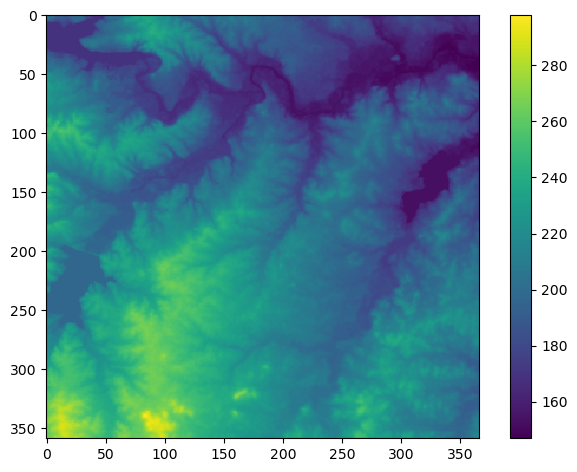

In [59]:
plt.imshow(shasta_dem, interpolation='none')
plt.colorbar()
plt.show()

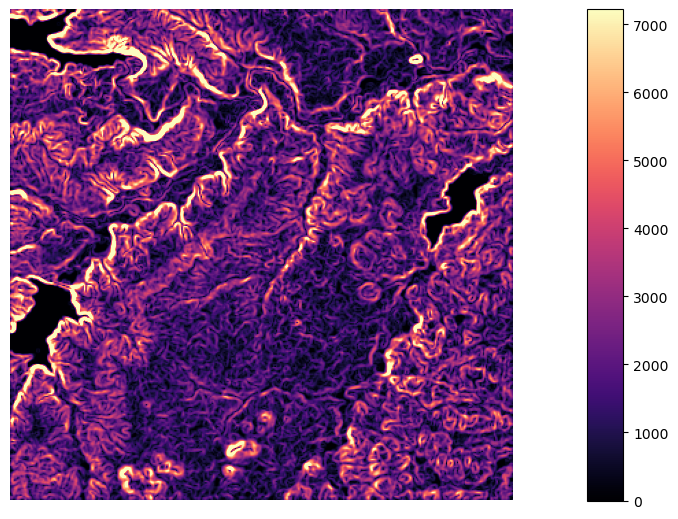

In [60]:
slope = rd.TerrainAttribute(shasta_dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

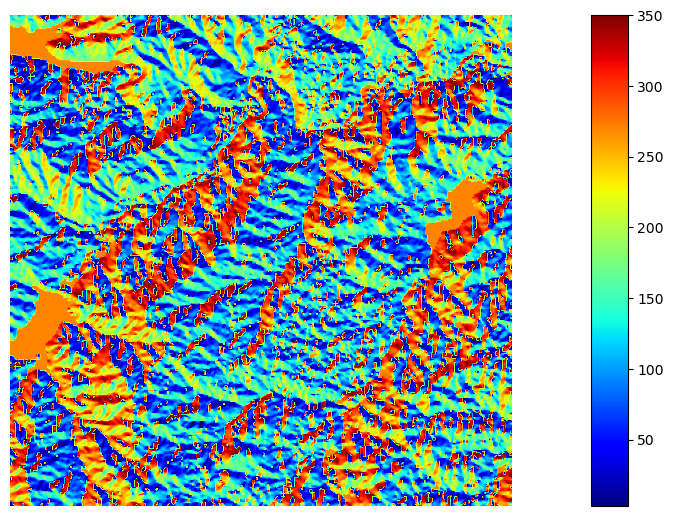

In [61]:
aspect = rd.TerrainAttribute(shasta_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()